# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

## 1. Download/Load SP500 stocks prices data.

In [32]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-02-19'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- SOLV: Data doesn't exist for startDate = 1456030800, endDate = 1708318800
- GEV: Data doesn't exist for startDate = 1456030800, endDate = 1708318800


adj close       close        high         low        open  \
date       ticker                                                               
2016-02-22 A        35.583687   38.029999   38.189999   37.779999   37.880001   
           AAL      39.135059   40.840000   40.930000   40.070000   40.139999   
           AAPL     22.489033   24.219999   24.225000   23.980000   24.077499   
           ABBV     41.686188   55.279999   55.320000   53.740002   54.290001   
           ABT      33.593941   39.160000   39.240002   38.529999   38.529999   
...                       ...         ...         ...         ...         ...   
2024-02-16 XYL     123.430000  123.790001  124.750000  123.500000  124.260002   
           YUM     134.550003  134.550003  135.850006  134.399994  135.229996   
           ZBH     124.475929  124.709999  125.959999  124.019997  124.150002   
           ZBRA    275.459991  275.459991  283.000000  271.709991  282.410004   
           ZTS     187.854370  188.389999  190.350006  187.929993  189.399994   

                        volume  
date       ticker               
2016-02-22 A         1792500.0  
           AAL       9997300.0  
           AAPL    137123200.0  
           ABBV      9381800.0  
           ABT       4946300.0  
...                        ...  
2024-02-16 XYL       1207700.0  
           YUM       2565900.0  
           ZBH       1455400.0  
           ZBRA       658200.0  
           ZTS       1953700.0  

[991144 rows x 6 columns]

In [33]:
df1 = df.copy()

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [34]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

adj close       close        high         low        open  \
date       ticker                                                               
2016-02-22 A        35.583687   38.029999   38.189999   37.779999   37.880001   
           AAL      39.135059   40.840000   40.930000   40.070000   40.139999   
           AAPL     22.489033   24.219999   24.225000   23.980000   24.077499   
           ABBV     41.686188   55.279999   55.320000   53.740002   54.290001   
           ABT      33.593941   39.160000   39.240002   38.529999   38.529999   
...                       ...         ...         ...         ...         ...   
2024-02-16 XYL     123.430000  123.790001  124.750000  123.500000  124.260002   
           YUM     134.550003  134.550003  135.850006  134.399994  135.229996   
           ZBH     124.475929  124.709999  125.959999  124.019997  124.150002   
           ZBRA    275.459991  275.459991  283.000000  271.709991  282.410004   
           ZTS     187.854370  188.389999  190.350006  187.929993  189.399994   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-02-22 A         1792500.0         -0.001452        NaN       NaN   
           AAL       9997300.0         -0.000023        NaN       NaN   
           AAPL    137123200.0         -0.001748        NaN       NaN   
           ABBV      9381800.0         -0.026538        NaN       NaN   
           ABT       4946300.0         -0.007093        NaN       NaN   
...                        ...               ...        ...       ...   
2024-02-16 XYL       1207700.0          0.000033  67.031514  4.691497   
           YUM       2565900.0          0.000048  60.908968  4.847163   
           ZBH       1455400.0          0.000118  54.861747  4.791199   
           ZBRA       658200.0          0.000589  59.791720  5.455600   
           ZTS       1953700.0          0.000056  48.025341  5.209881   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-02-22 A            NaN       NaN       NaN       NaN      63.783759  
           AAL          NaN       NaN       NaN       NaN     391.244929  
           AAPL         NaN       NaN       NaN       NaN    3083.768135  
           ABBV         NaN       NaN       NaN       NaN     391.091476  
           ABT          NaN       NaN       NaN       NaN     166.165709  
...                     ...       ...       ...       ...            ...  
2024-02-16 XYL     4.773554  4.855611  0.418786  1.938196     149.066411  
           YUM     4.879582  4.912001  0.405624  0.590616     345.241853  
           ZBH     4.825745  4.860290 -0.052505  0.274679     181.162267  
           ZBRA    5.536252  5.616905  0.702097  0.411970     181.307766  
           ZTS     5.252651  5.295421  1.121372 -0.468583     367.011083  

[991144 rows x 14 columns]

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [36]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-03-31 A           61.913030   37.286610 -1.193056  3.663641  3.597363   
           AAL        298.909249   39.297955  0.049150  3.753792  3.680381   
           AAPL      3281.979611   25.300169 -1.126014  3.277603  3.182497   
           ABBV       272.672987   43.073711 -1.024805  3.796388  3.751199   
           ABT        228.109908   35.884434 -1.176595  3.614525  3.527731   
...                          ...         ...       ...       ...       ...   
2024-02-29 ABNB      1018.995218  152.509995 -0.416731  5.059982  4.943408   
           CEG        232.674964  130.902756  0.994008  4.924816  4.755358   
           GEHC       361.426308   85.989708  0.615311  4.487896  4.242439   
           KVUE       375.441574   19.049999 -1.340827  3.109620  2.981765   
           VLTO       127.687862   86.089996 -0.226520  4.473669  4.309719   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2016-03-31 A       3.630502         -0.001859  0.134656  58.307841  
           AAL     3.717086         -0.001005  0.098304  46.582218  
           AAPL    3.230050         -0.002480  0.074838  75.205235  
           ABBV    3.773794         -0.030329 -0.093600  55.157706  
           ABT     3.571128         -0.008507  0.357079  70.139119  
...                     ...               ...       ...        ...  
2024-02-29 ABNB    5.001695          0.000185  0.748208  57.625182  
           CEG     4.840087          0.000133  1.397424  62.101530  
           GEHC    4.365168          0.000660  1.413346  70.602980  
           KVUE    3.045692          0.000046 -0.684736  36.462782  
           VLTO    4.391694          0.000049  1.402193  64.932721  

[47284 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [37]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-02-28 AAL      44.898853  0.248804  3.864723  3.767394  3.816059   
           AAPL     32.472145 -1.199835  3.542688  3.419032  3.480860   
           ABBV     48.415981 -1.528547  3.908773  3.871400  3.890087   
           ABT      39.651764 -1.282245  3.729226  3.619543  3.674385   
           ACN     109.147270 -1.115161  4.727681  4.610400  4.669041   
...                       ...       ...       ...       ...       ...   
2024-02-29 WMT      56.593918 -0.018296  4.069887  3.997925  4.033906   
           XOM     103.730003  0.507312  4.666141  4.587510  4.626826   
           MRNA     88.370003 -0.477386  4.705877  4.447610  4.576743   
           UBER     78.410004  2.320505  4.385440  4.117983  4.251712   
           ABNB    152.509995 -0.416731  5.059982  4.943408  5.001695   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2017-02-28 AAL            -0.000264  0.099999  50.168949  
           AAPL           -0.001107  0.192982  84.344950  
           ABBV           -0.023900 -0.147493  53.680481  
           ABT            -0.007014  0.659567  71.877293  
           ACN            -0.005284  0.164693  63.222889  
...                             ...       ...        ...  
2024-02-29 WMT             0.000116  1.464882  65.553639  
           XOM             0.000054  0.516725  56.892398  
           MRNA            0.000562 -0.373846  43.106671  
           UBER            0.000327  2.758667  70.640061  
           ABNB            0.000185  0.748208  57.625182  

[12665 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [38]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-02-28 AAL      52.977318  1.372150  4.015218  3.875603  3.945411   
           AAPL     42.889526 -0.802672  3.809132  3.631005  3.720069   
           ABBV     93.723679  1.929271  4.601392  4.482005  4.541699   
           ABT      54.206100 -0.611134  4.046596  3.942635  3.994616   
           ACN     146.351868 -0.522548  5.027020  4.928600  4.977810   
...                       ...       ...       ...       ...       ...   
2024-02-29 WMT      56.593918 -0.018296  4.069887  3.997925  4.033906   
           XOM     103.730003  0.507312  4.666141  4.587510  4.626826   
           MRNA     88.370003 -0.477386  4.705877  4.447610  4.576743   
           UBER     78.410004  2.320505  4.385440  4.117983  4.251712   
           ABNB    152.509995 -0.416731  5.059982  4.943408  5.001695   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-02-28 AAL            -0.000118  0.442127  55.685240   0.000632   
           AAPL           -0.000642 -0.015867  59.836035   0.068185   
           ABBV           -0.021383  1.156026  56.507205   0.032169   
           ABT            -0.004782 -0.048326  55.823985  -0.029440   
           ACN            -0.004209  0.099869  54.875648   0.001929   
...                             ...       ...        ...        ...   
2024-02-29 WMT             0.000116  1.464882  65.553639   0.030923   
           XOM             0.000054  0.516725  56.892398   0.018325   
           MRNA            0.000562 -0.373846  43.106671  -0.125482   
           UBER            0.000327  2.758667  70.640061   0.201318   
           ABNB            0.000185  0.748208  57.625182   0.058069   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-02-28 AAL      0.022092   0.024888   0.033351   0.013426    0.013883  
           AAPL     0.028019   0.013390   0.015155   0.018521    0.023458  
           ABBV     0.098315   0.063744   0.076940   0.065844    0.050362  
           ABT      0.030620   0.024517   0.030254   0.033180    0.026397  
           ACN      0.025541   0.028460   0.036957   0.030116    0.024744  
...                      ...        ...        ...        ...         ...  
2024-02-29 WMT      0.039530   0.031745   0.008413   0.017442    0.016494  
           XOM      0.023303   0.006300  -0.008480   0.004630   -0.001891  
           MRNA    -0.057351   0.043826  -0.040247  -0.040089   -0.036932  
           UBER     0.128499   0.116217   0.088159   0.084035    0.074082  
           ABNB     0.058416   0.064762   0.024947   0.037214    0.017889  

[10497 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [39]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-02-28 AAL    -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.000632
           AAPL   -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.068185
           ABBV   -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.032169
           ABT    -0.0365  0.0032 -0.0104  0.0052 -0.0237  -0.029440
           ACN    -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.001929
...                   ...     ...     ...     ...     ...        ...
2024-02-29 VRTX    0.0506 -0.0078 -0.0348 -0.0198 -0.0213  -0.025797
           VZ      0.0506 -0.0078 -0.0348 -0.0198 -0.0213  -0.043920
           WFC     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.041742
           WMT     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.030923
           XOM     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.018325

[10497 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [40]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-02-28 AAL    -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.000632
           AAPL   -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.068185
           ABBV   -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.032169
           ABT    -0.0365  0.0032 -0.0104  0.0052 -0.0237  -0.029440
           ACN    -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.001929
...                   ...     ...     ...     ...     ...        ...
2024-02-29 VRTX    0.0506 -0.0078 -0.0348 -0.0198 -0.0213  -0.025797
           VZ      0.0506 -0.0078 -0.0348 -0.0198 -0.0213  -0.043920
           WFC     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.041742
           WMT     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.030923
           XOM     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.018325

[10477 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [41]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-02-28 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-02-29 VRTX    0.328874  0.590146 -0.883027  0.207896  1.150981
           VZ      0.471847 -1.130906  0.777187  0.125092 -0.487067
           WFC     1.085758  0.329469  1.628377 -0.235809 -1.303109
           WMT     0.531301  0.268531 -0.933419  0.643033  0.935060
           XOM     0.808291 -0.003644  0.470713  0.840784  0.574973

[10477 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [42]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10286 entries, (Timestamp('2018-02-28 00:00:00'), 'AAL') to (Timestamp('2024-02-29 00:00:00'), 'UBER')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10286 non-null  float64
 1   bb_high           10286 non-null  float64
 2   bb_low            10286 non-null  float64
 3   bb_mid            10286 non-null  float64
 4   garman_klass_vol  10286 non-null  float64
 5   macd              10286 non-null  float64
 6   rsi               10286 non-null  float64
 7   return_1m         10286 non-null  float64
 8   return_2m         10286 non-null  float64
 9   return_3m         10286 non-null  float64
 10  return_6m         10286 non-null  float64
 11  return_9m         10286 non-null  float64
 12  return_12m        10286 non-null  float64
 13  Mkt-RF            10286 non-null  float64
 14  SMB               10286 non-null  float64
 15  HML       

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [43]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [44]:
from sklearn.cluster import KMeans

#data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-02-28 AAL     1.372150  4.015218  3.875603  3.945411         -0.000118   
           AAPL   -0.802672  3.809132  3.631005  3.720069         -0.000642   
           ABBV    1.929271  4.601392  4.482005  4.541699         -0.021383   
           ABT    -0.611134  4.046596  3.942635  3.994616         -0.004782   
           ACN    -0.522548  5.027020  4.928600  4.977810         -0.004209   
...                     ...       ...       ...       ...               ...   
2024-02-29 WFC     0.406281  3.962334  3.872545  3.917439          0.000186   
           WMT    -0.018296  4.069887  3.997925  4.033906          0.000116   
           XOM     0.507312  4.666141  4.587510  4.626826          0.000054   
           MRNA   -0.477386  4.705877  4.447610  4.576743          0.000562   
           UBER    2.320505  4.385440  4.117983  4.251712          0.000327   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-02-28 AAL     0.442127  55.685240   0.000632   0.022092   0.024888   
           AAPL   -0.015867  59.836035   0.068185   0.028019   0.013390   
           ABBV    1.156026  56.507205   0.032169   0.098315   0.063744   
           ABT    -0.048326  55.823985  -0.029440   0.030620   0.024517   
           ACN     0.099869  54.875648   0.001929   0.025541   0.028460   
...                     ...        ...        ...        ...        ...   
2024-02-29 WFC     0.634199  64.502998   0.041742   0.030563   0.054430   
           WMT     1.464882  65.553639   0.030923   0.039530   0.031745   
           XOM     0.516725  56.892398   0.018325   0.023303   0.006300   
           MRNA   -0.373846  43.106671  -0.125482  -0.057351   0.043826   
           UBER    2.758667  70.640061   0.201318   0.128499   0.116217   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-02-28 AAL      0.033351   0.013426    0.013883  1.257822  1.365269   
           AAPL     0.015155   0.018521    0.023458  1.318512 -0.344364   
           ABBV     0.076940   0.065844    0.050362  0.448794  0.493497   
           ABT      0.030254   0.033180    0.026397  0.811161 -0.142601   
           ACN      0.036957   0.030116    0.024744  1.219137 -0.177697   
...                      ...        ...         ...       ...       ...   
2024-02-29 WFC      0.041638   0.032639    0.011375  1.079120  0.333249   
           WMT      0.008413   0.017442    0.016494  0.542268  0.232459   
           XOM     -0.008480   0.004630   -0.001891  0.784613  0.060257   
           MRNA    -0.040247  -0.040089   -0.036932  1.629141  1.096950   
           UBER     0.088159   0.084035    0.074082  1.291203  0.209765   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-02-28 AAL     0.496053  0.218395  0.721645        2  
           AAPL   -0.602465  0.489955  0.558401        3  
           ABBV   -0.132896  0.435409  0.333689        2  
           ABT    -0.492920  0.292254  0.974793        2  
           ACN    -0.293867  0.298210  0.157931        2  
...                     ...       ...       ...      ...  
2024-02-29 WFC     1.643035 -0.208227 -1.319135        2  
           WMT    -0.911311  0.668956  0.888276        2  
           XOM     0.444692  0.818322  0.641646        2  
           MRNA   -0.976323  0.968242  1.514646        0  
           UBER   -0.116221 -1.833575 -0.978257        3  

[10286 rows x 19 columns]

In [45]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


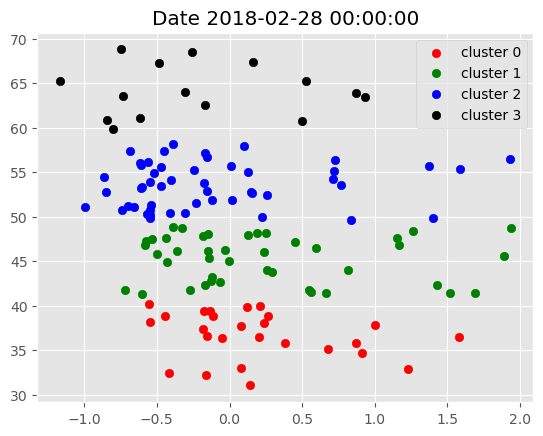

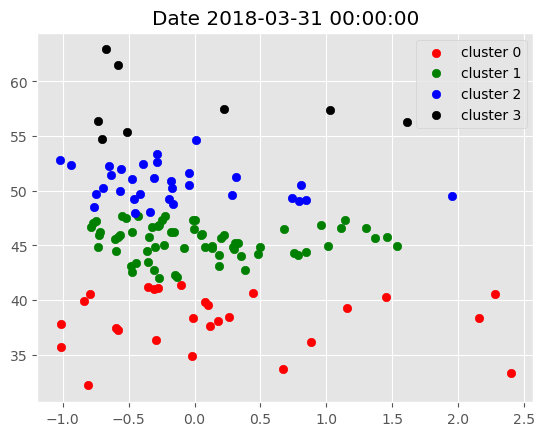

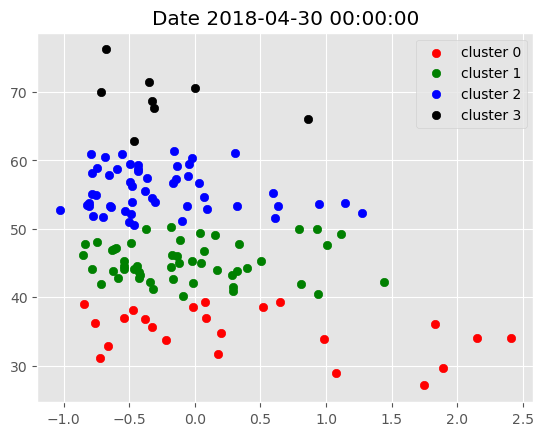

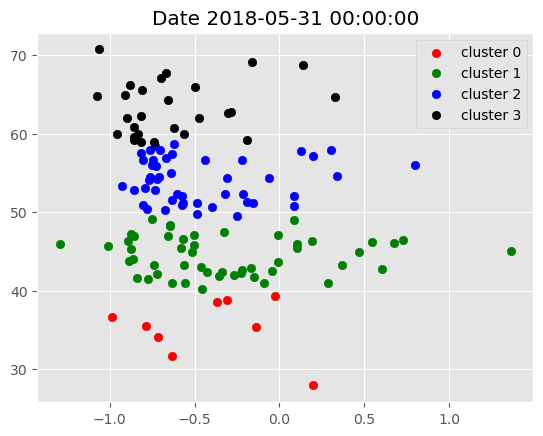

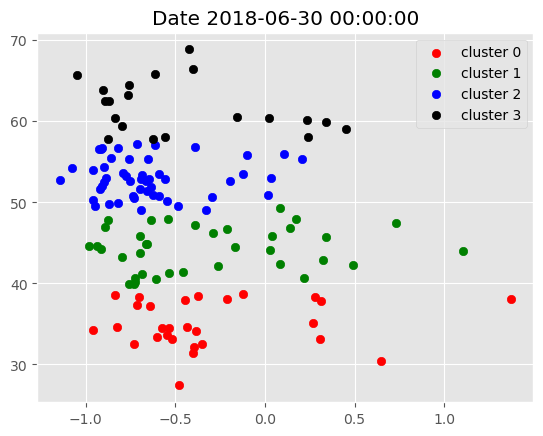

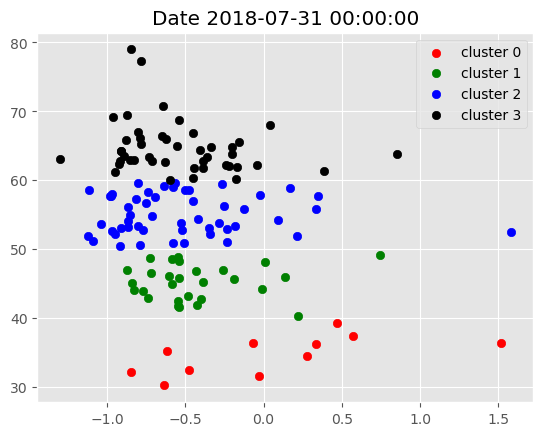

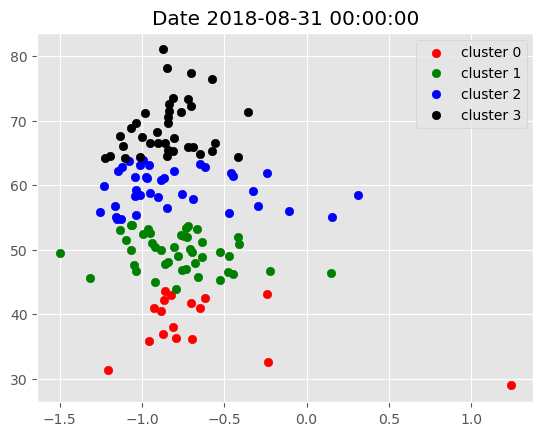

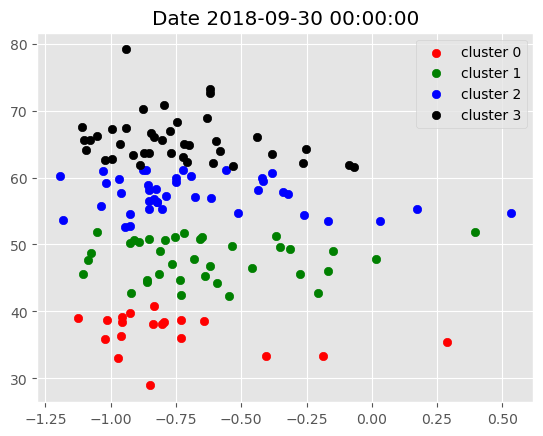

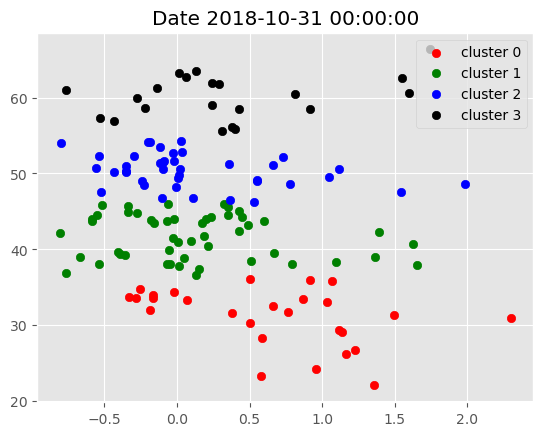

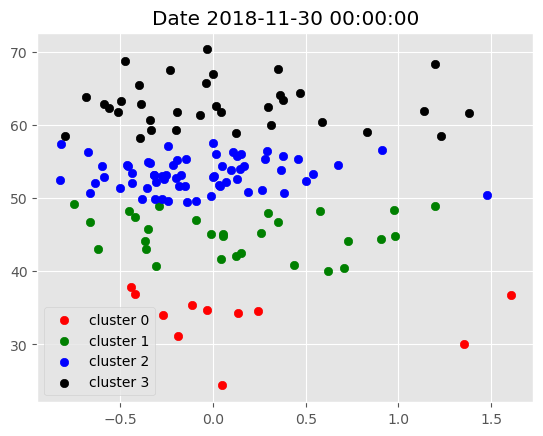

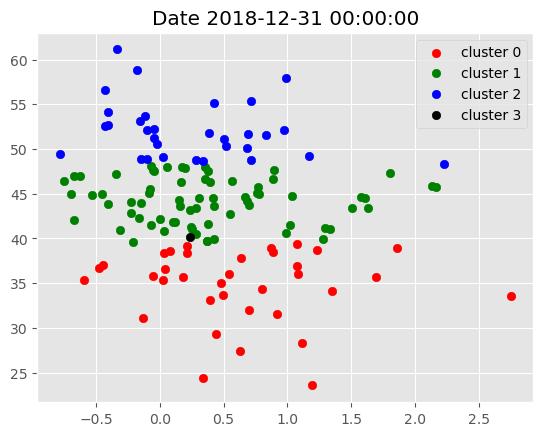

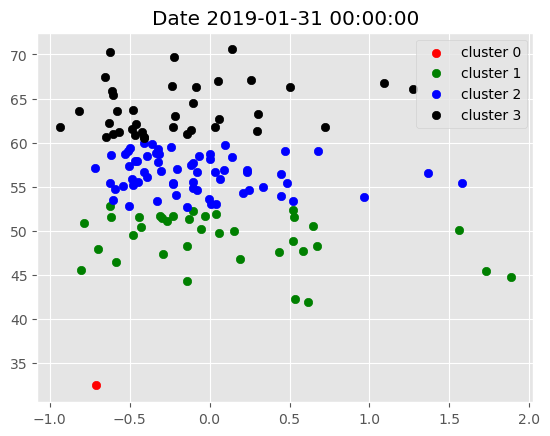

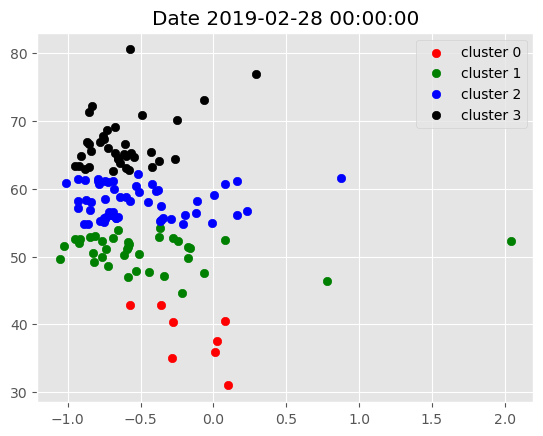

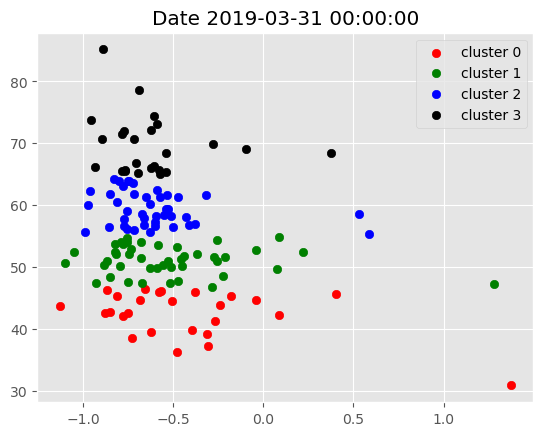

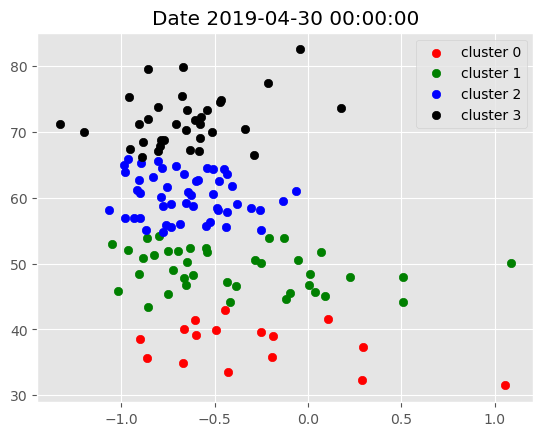

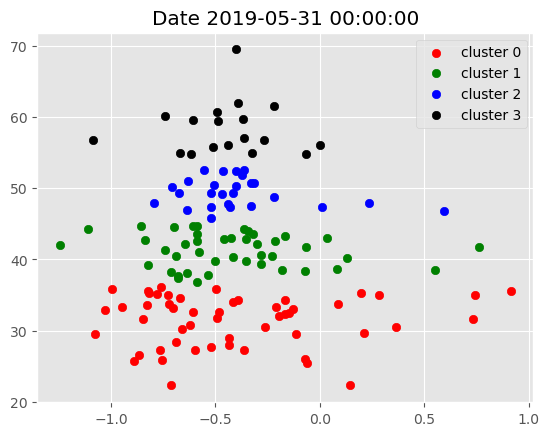

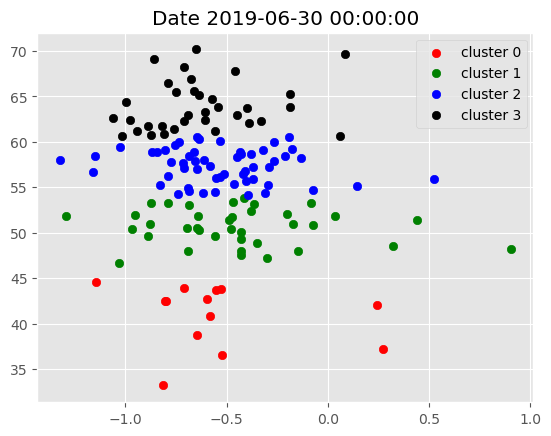

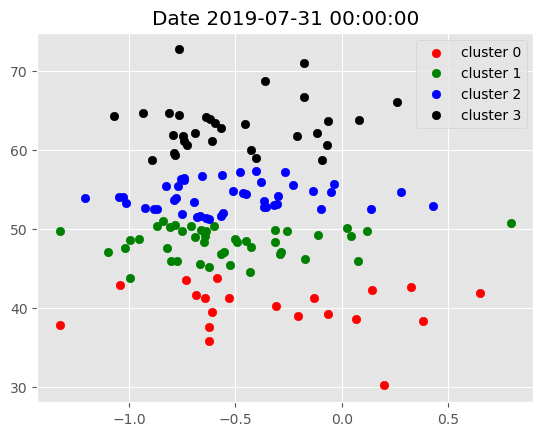

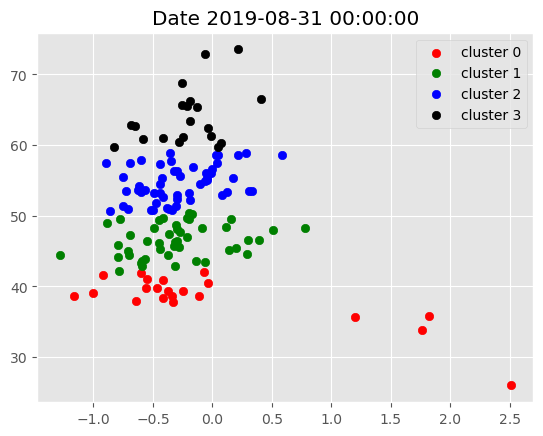

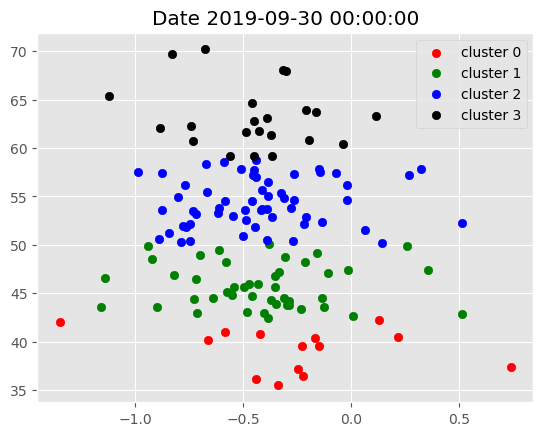

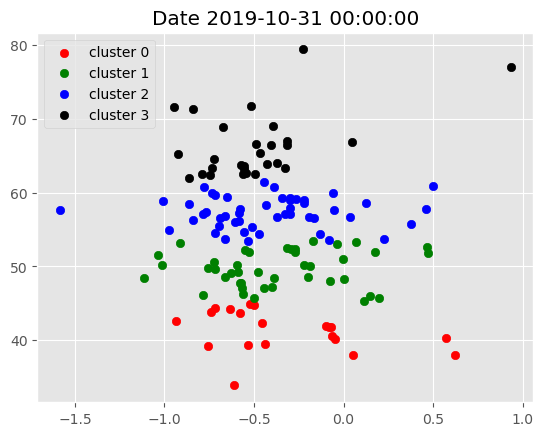

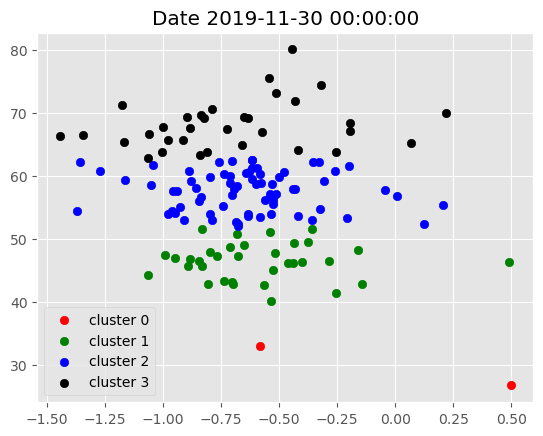

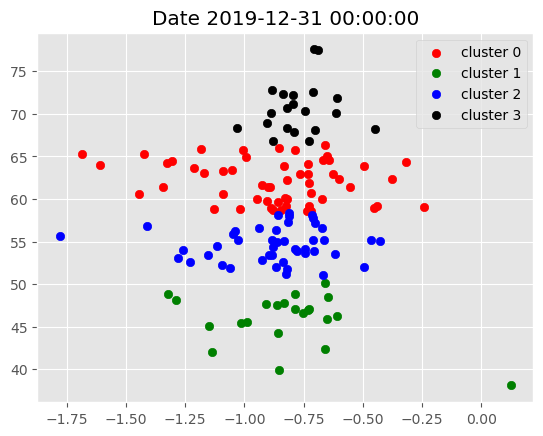

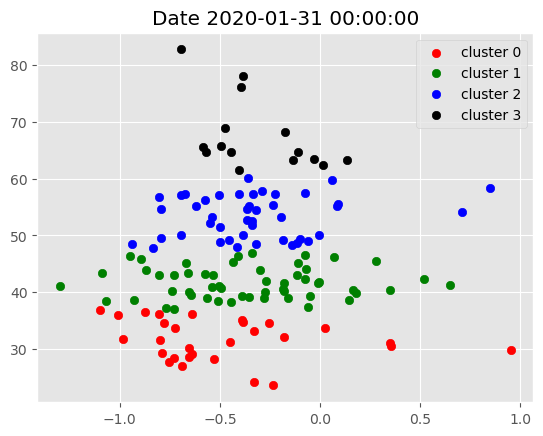

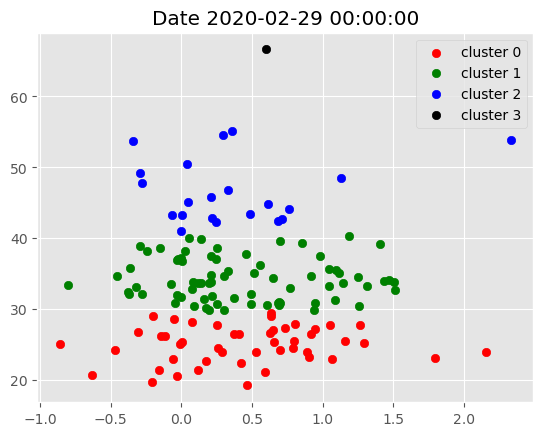

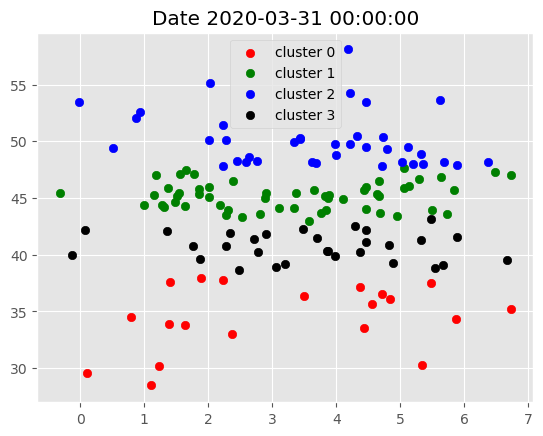

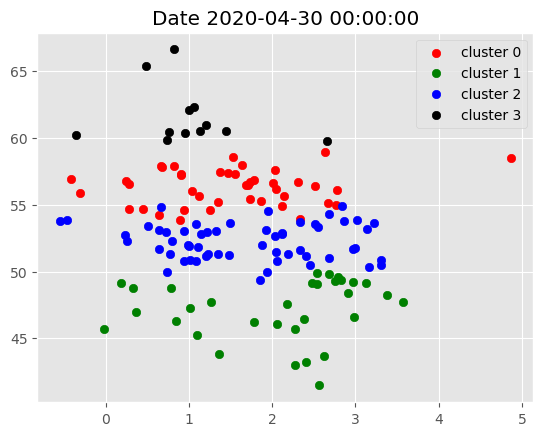

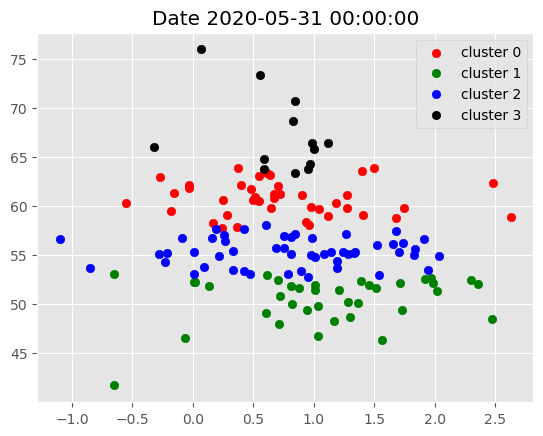

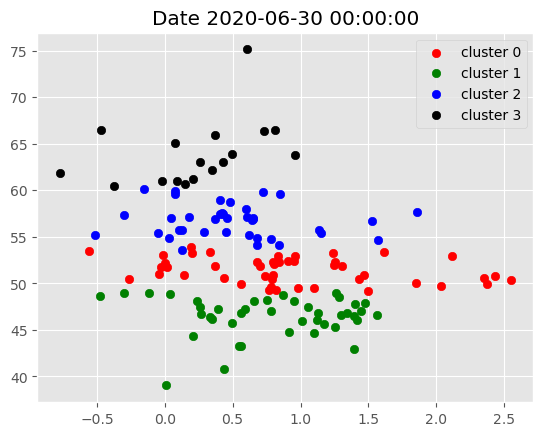

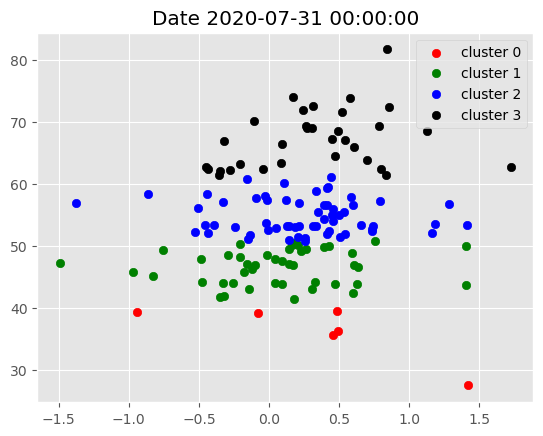

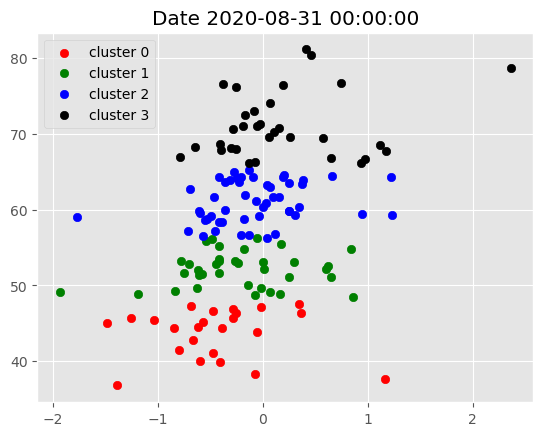

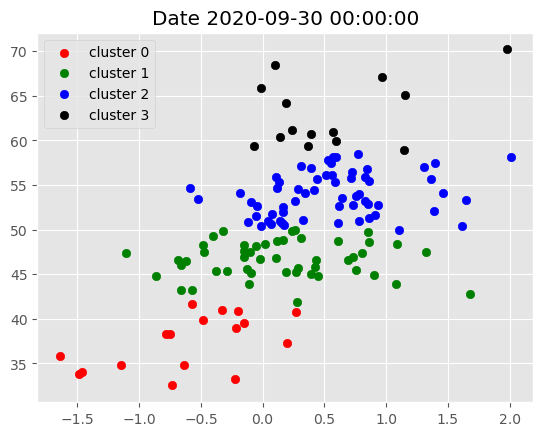

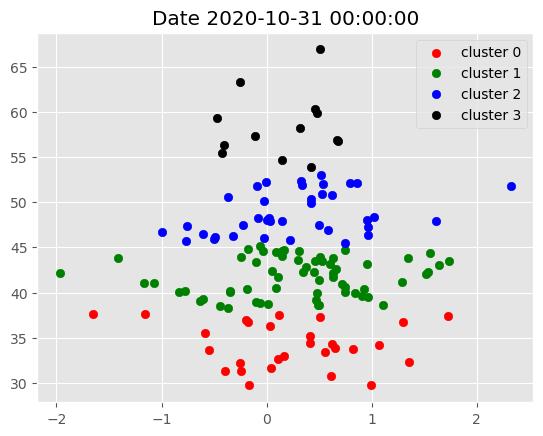

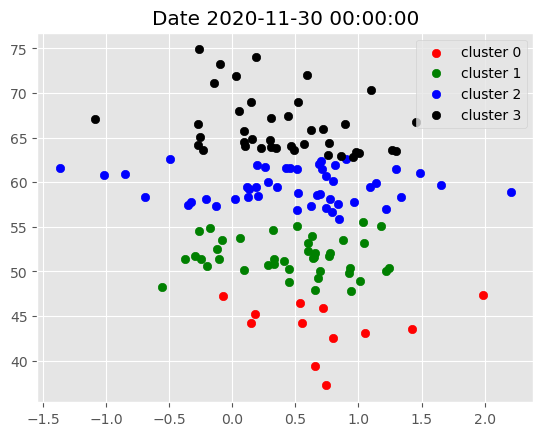

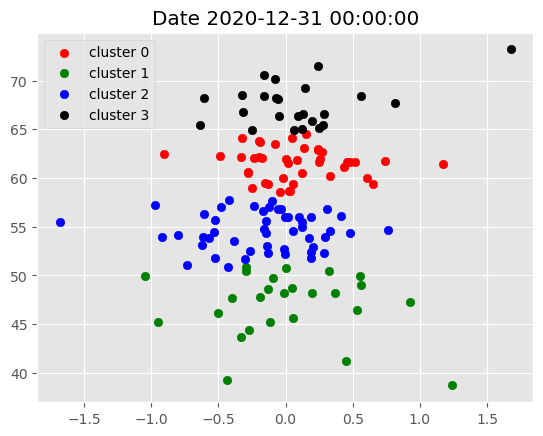

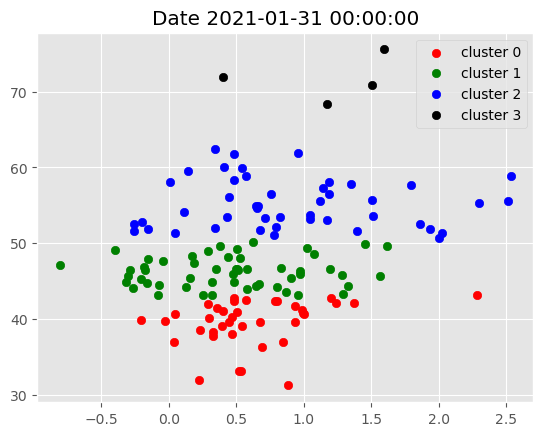

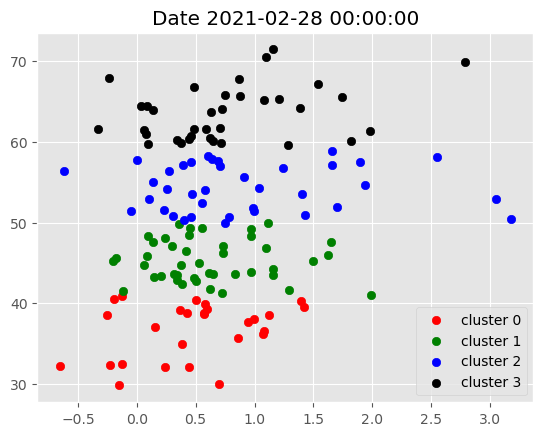

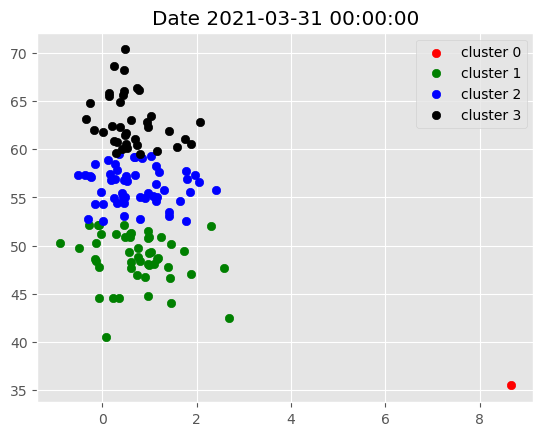

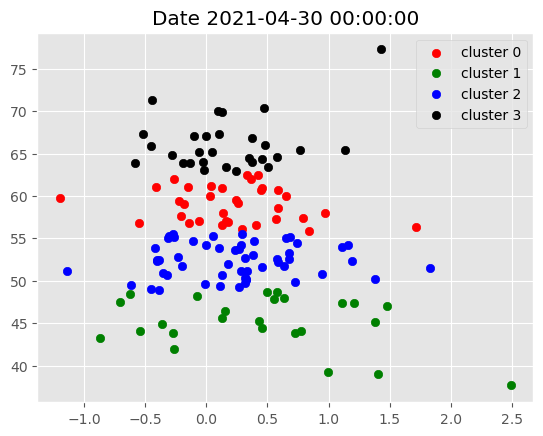

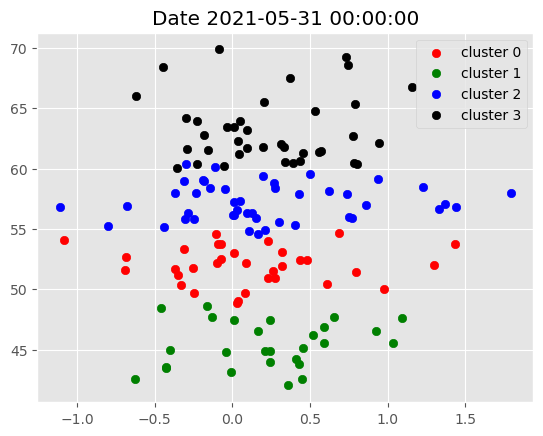

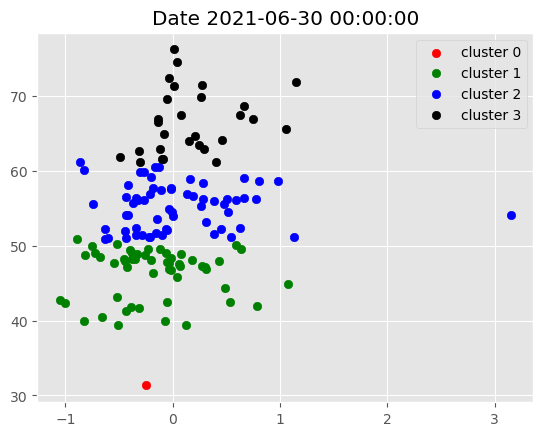

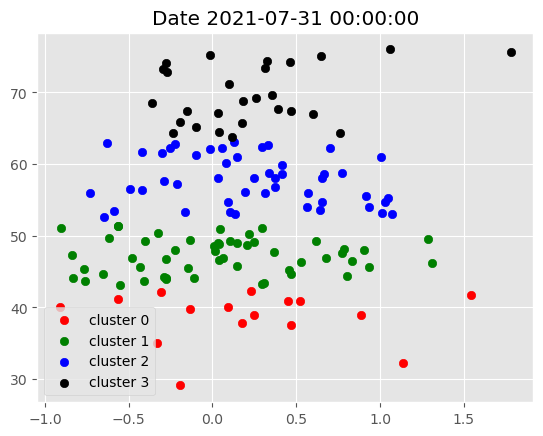

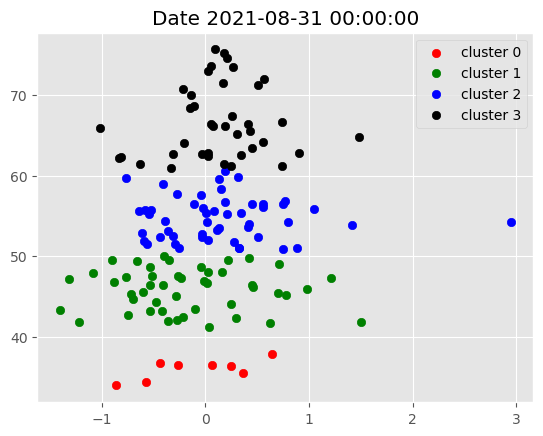

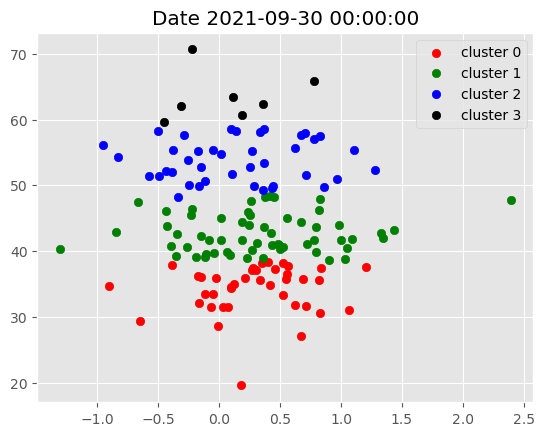

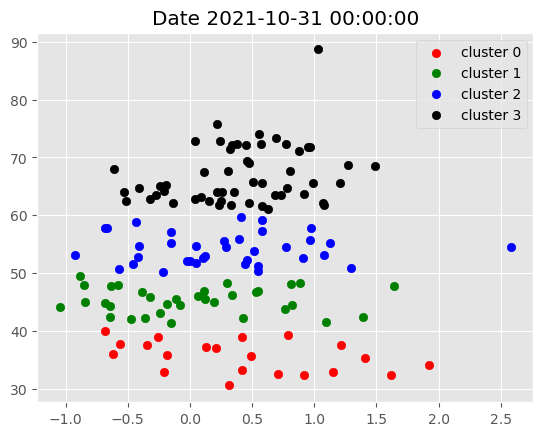

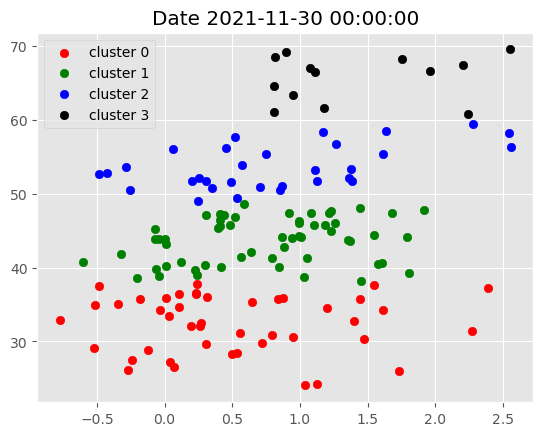

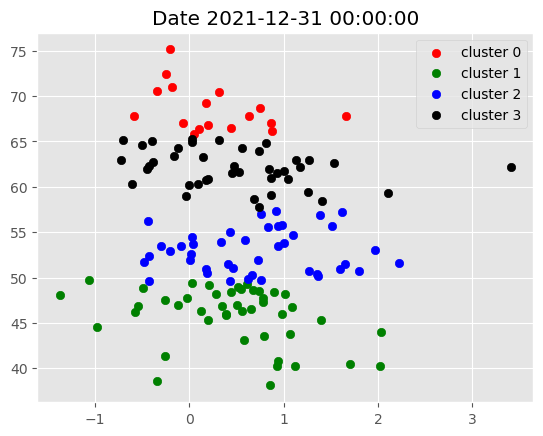

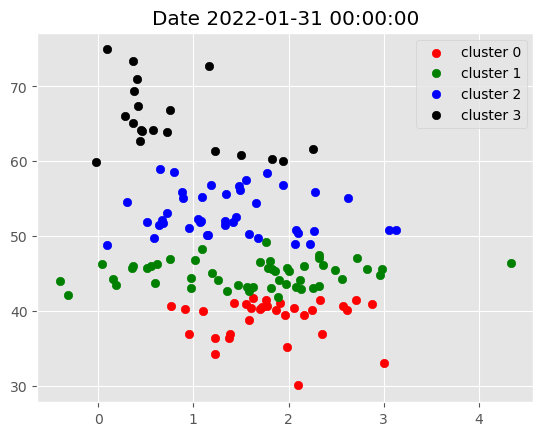

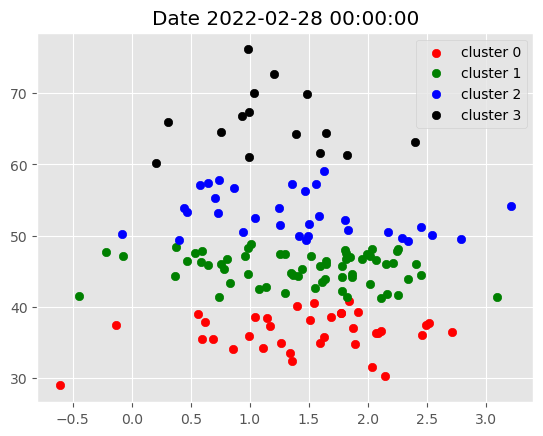

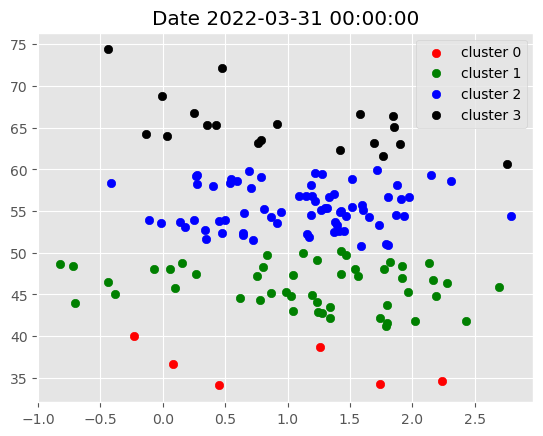

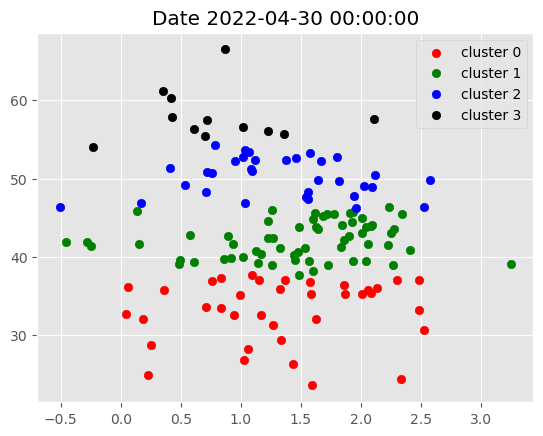

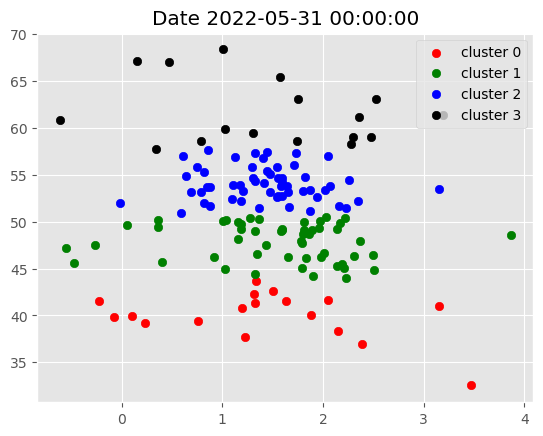

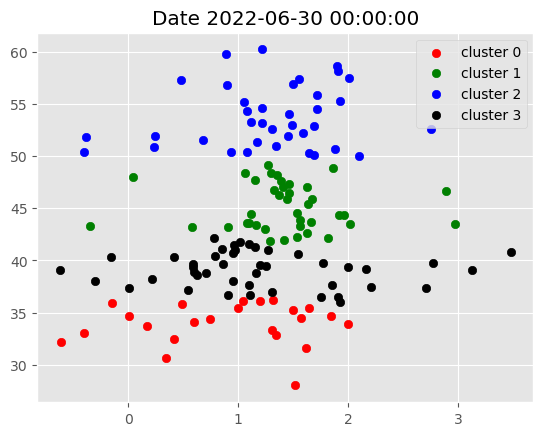

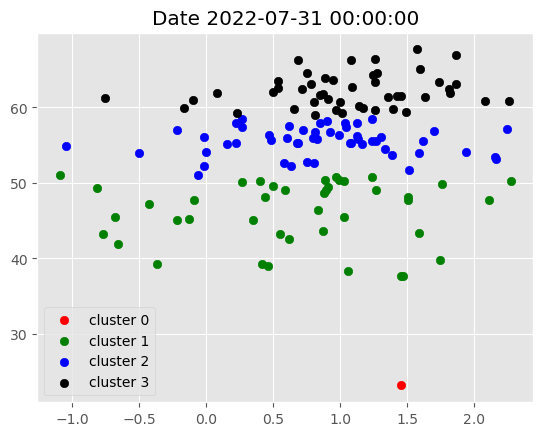

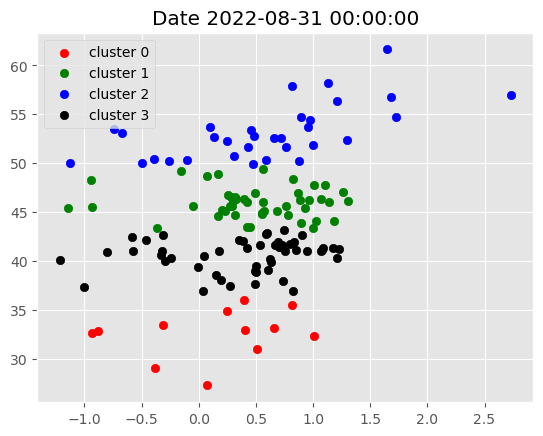

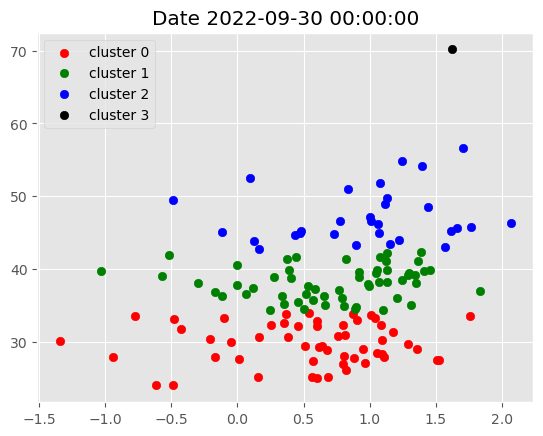

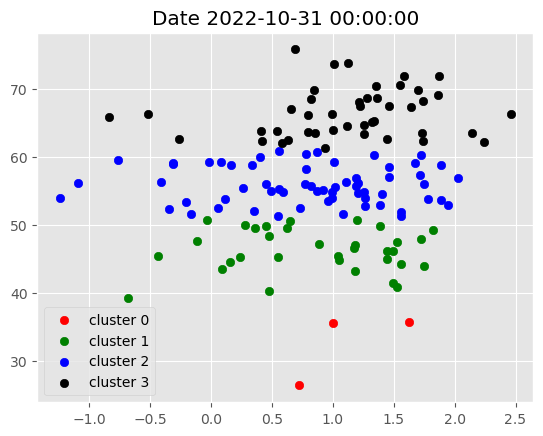

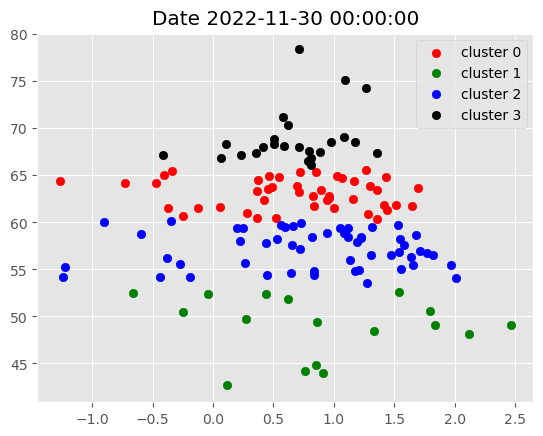

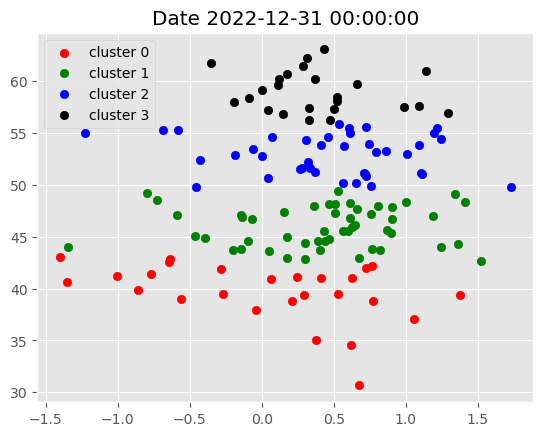

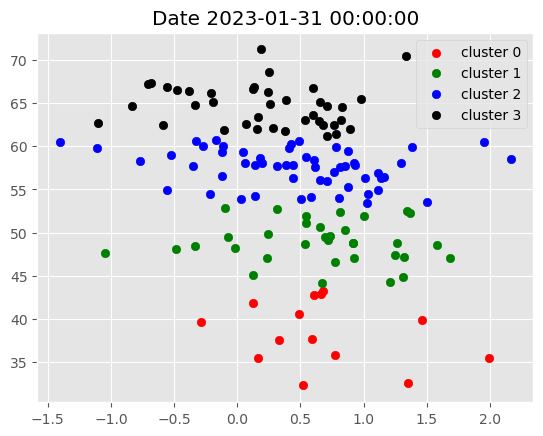

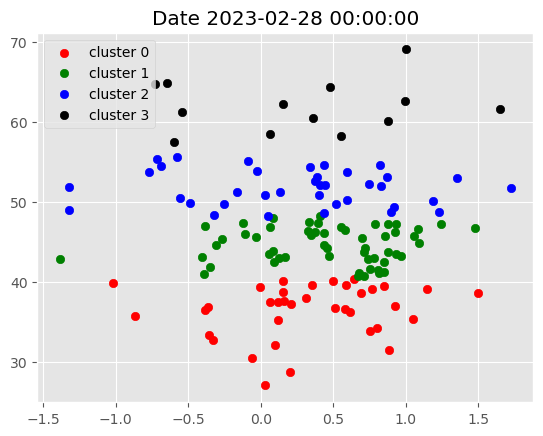

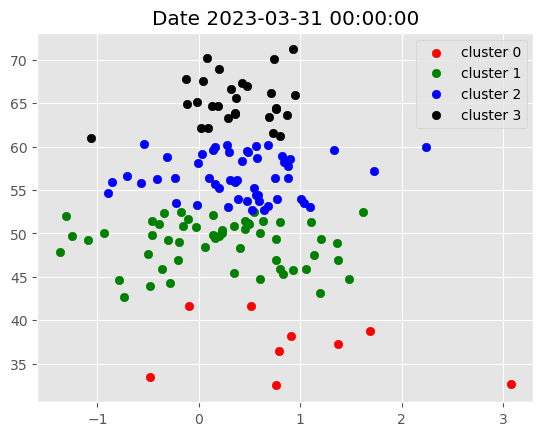

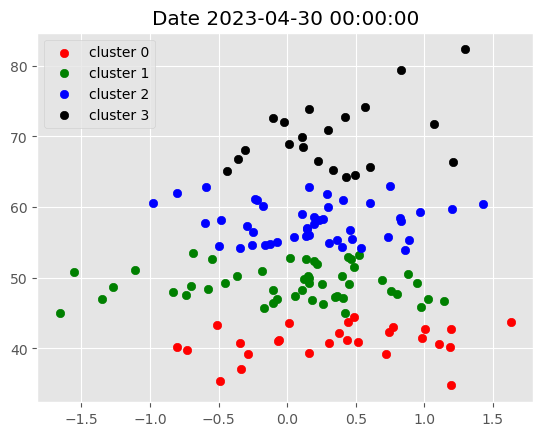

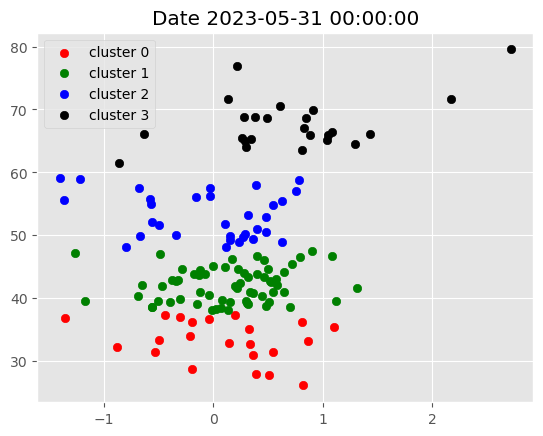

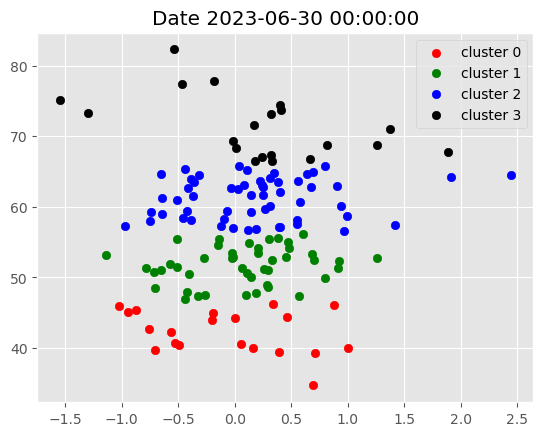

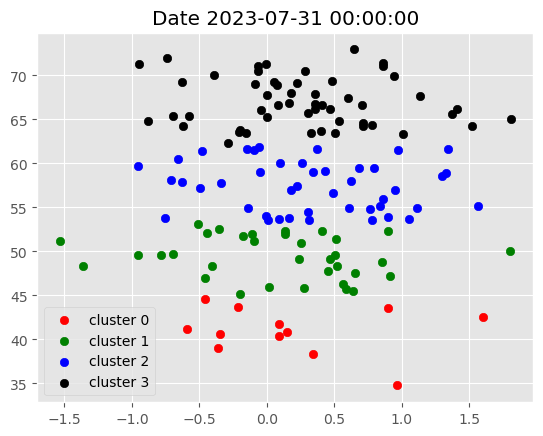

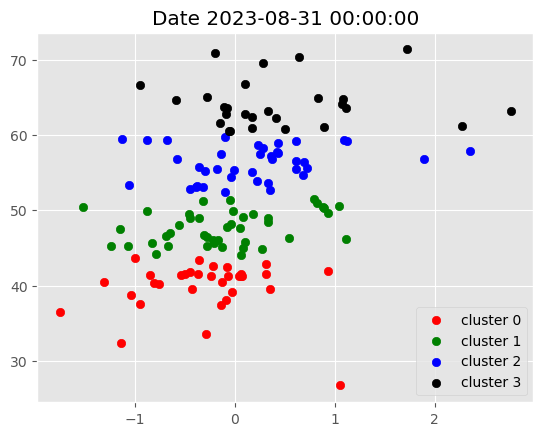

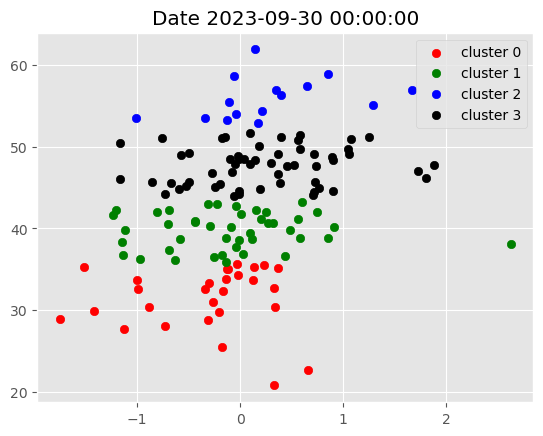

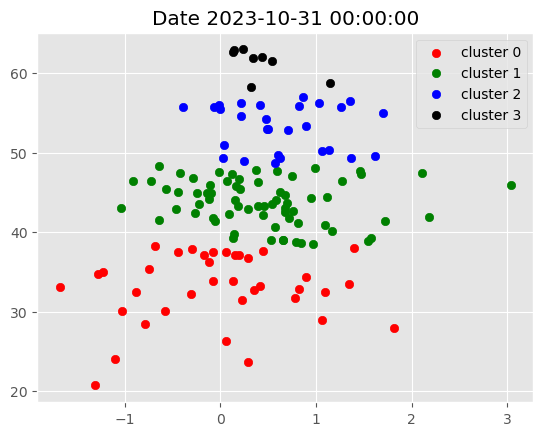

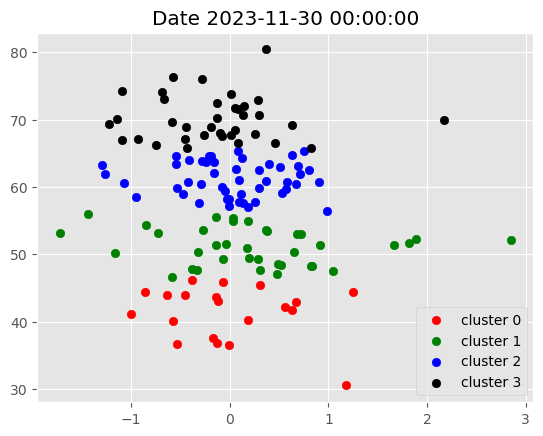

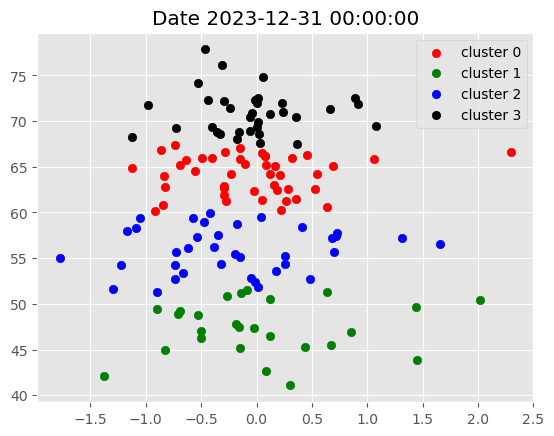

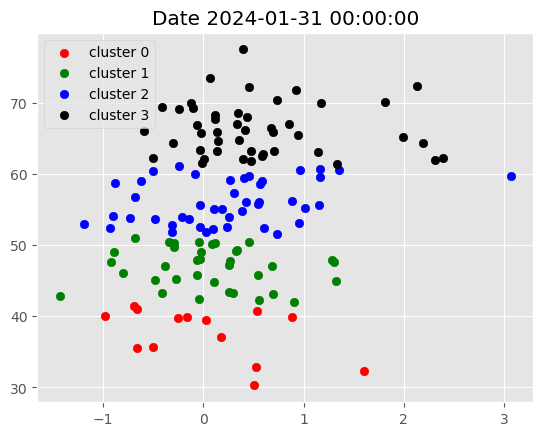

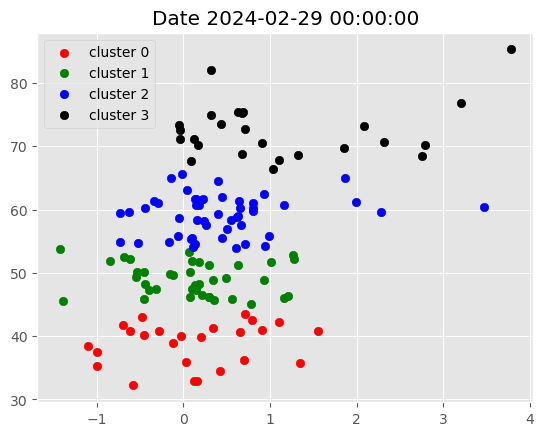

In [46]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

### Apply pre-defined centroids.

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [47]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-03-01': ['AAPL',
  'ADBE',
  'AMZN',
  'BA',
  'BKNG',
  'CRM',
  'CSCO',
  'CTSH',
  'INTC',
  'MA',
  'MU',
  'NFLX',
  'NXPI',
  'PANW',
  'TJX'],
 '2018-04-01': ['AMT', 'COP', 'INTC', 'NEE', 'PANW', 'STZ', 'TJX', 'WYNN'],
 '2018-05-01': ['CMG', 'COP', 'EOG', 'HAL', 'OXY', 'PXD', 'ULTA', 'VLO'],
 '2018-06-01': ['AAPL',
  'ADBE',
  'AMD',
  'AMZN',
  'AVGO',
  'BIIB',
  'CMG',
  'CSX',
  'DVN',
  'EXPE',
  'GM',
  'LLY',
  'LOW',
  'MDT',
  'META',
  'MSFT',
  'NEE',
  'NFLX',
  'NKE',
  'OXY',
  'PANW',
  'PYPL',
  'QCOM',
  'TJX',
  'TXN',
  'UPS',
  'V',
  'VLO'],
 '2018-07-01': ['ACN',
  'AMT',
  'COST',
  'CRM',
  'DVN',
  'EA',
  'EOG',
  'KR',
  'MDLZ',
  'NEE',
  'NFLX',
  'NKE',
  'PARA',
  'PEP',
  'PG',
  'REGN',
  'SHW',
  'SPG',
  'TJX',
  'VZ'],
 '2018-08-01': ['ABT',
  'AMD',
  'AMGN',
  'AMT',
  'BMY',
  'C',
  'CMCSA',
  'COST',
  'CSX',
  'DIS',
  'ELV',
  'EOG',
  'EXPE',
  'GILD',
  'HON',
  'JNJ',
  'JPM',
  'KO',
  'KR',
  'LLY',
  'LMT',
  'LUV',
  'MDLZ

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [48]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [49]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%***********************]  157 of 157 completed


Adj Close                                                  \
                  AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-02-28  44.898846   32.472145   48.415981   41.381310  112.948448   
2017-03-01  45.605846   33.135860   49.191074   41.849457  114.396034   
2017-03-02  44.279018   32.939114   49.519905   41.941265  114.654205   
2017-03-03  45.344345   33.133476   49.590366   41.537365  113.999565   
2017-03-06  43.881943   33.029186   49.754768   41.427204  113.630768   
...               ...         ...         ...         ...         ...   
2024-02-22  15.240000  184.369995  176.750000  119.019997  371.309998   
2024-02-23  15.130000  182.520004  178.089996  119.459999  377.320007   
2024-02-26  15.280000  181.160004  178.809998  118.690002  377.480011   
2024-02-27  15.540000  182.630005  178.990005  119.400002  377.910004   
2024-02-28  15.460000  181.419998  178.000000  120.050003  378.029999   

                                                                       ...  \
                  ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2017-02-28  118.339996   93.130936   86.300003  55.637619   34.197830  ...   
2017-03-01  120.349998   94.864342   88.930000  56.255615   34.792656  ...   
2017-03-02  119.900002   94.446877   87.320000  55.620213   34.452759  ...   
2017-03-03  120.040001   94.837105   85.320000  55.898746   34.811543  ...   
2017-03-06  120.150002   95.245483   82.940002  55.515755   34.802105  ...   
...                ...         ...         ...        ...         ...  ...   
2024-02-22  537.570007  254.759995  256.980011  70.879997  199.729996  ...   
2024-02-23  553.440002  255.869995  257.200012  71.320000  197.160004  ...   
2024-02-26  560.479980  253.550003  257.350006  71.320000  203.550003  ...   
2024-02-27  552.489990  251.309998  256.950012  71.949997  202.860001  ...   
2024-02-28  551.820007  251.559998  255.250000  72.430000  197.539993  ...   

              Volume                                                           \
                   V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2017-02-28   8521900  9074700  2401900  17699200   3879900  5078100  15558900   
2017-03-01  11131400  4921900  2089400  16095600   3390500  4667800  25912700   
2017-03-02  10544200  7343000  1060900  10773400   3096800  4867100  17578600   
2017-03-03   5700600  4046600  1422600  11071600   3157600  3223100  14740000   
2017-03-06   7347600  3315300  1587700  10827300   2437500  3855000  13225500   
...              ...      ...      ...       ...       ...      ...       ...   
2024-02-22   5100200  3467800  1091800  22068900  11972600  5101200  20467900   
2024-02-23   5107700  2520800   749700  15228600  31886700  3163600  20863500   
2024-02-26   3856900  3350600   788000  25108400  13650200  6165000  18099900   
2024-02-27   4145200  3047800   917400  17074100   9055000  6304300  19548200   
2024-02-28   4358800  3895200   786600  12437000   8841200  4133900  20045200   

                                         
                 WMT     WYNN       XOM  
Date                                     
2017-02-28  47857800  2094100  16834200  
2017-03-01  40568100  6088500  17482100  
2017-03-02  26748900  2754100  14170300  
2017-03-03  27893700  1782100  12190400  
2017-03-06  27547800  1206000   9617200  
...              ...      ...       ...  
2024-02-22  29512800  1020300  20470700  
2024-02-23  74365800  1515700  15975900  
2024-02-26  32154800  1176800  13360800  
2024-02-27  18012700  1536900  16360000  
2024-02-28  14803300  1327500  14810500  

[1762 rows x 942 columns]

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [50]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-11-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2018-03-01,-0.012671
2018-03-02,0.010836
2018-03-05,0.017757
2018-03-06,0.006996
2018-03-07,0.002144
...,...
2024-02-22,0.033683
2024-02-23,0.007732
2024-02-26,0.006381


## 8. Visualize Portfolio returns and compare to SP500 returns.

In [51]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2018-03-01,-0.012671,-0.014647
2018-03-02,0.010836,0.005142
2018-03-05,0.017757,0.011492
2018-03-06,0.006996,0.002532
2018-03-07,0.002144,-0.000367
...,...,...
2024-02-22,0.033683,0.020484
2024-02-23,0.007732,0.000689
2024-02-26,0.006381,-0.003669
2024-02-27,0.002644,0.001856


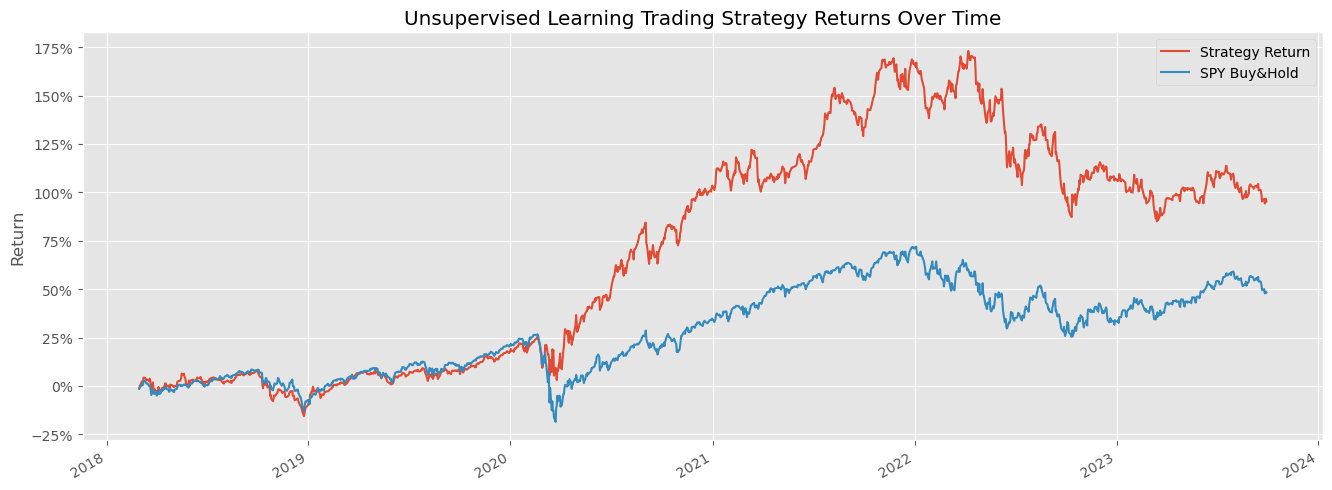

In [52]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()


# Intraday Strategy Using GARCH Model


* Using simulated daily data and intraday 5-min data.
* Load Daily and 5-minute data.
* Define function to fit GARCH model on the daily data and predict 1-day ahead volatility in a rolling window.
* Calculate prediction premium and form a daily signal from it.
* Merge with intraday data and calculate intraday indicators to form the intraday signal.
* Generate the position entry and hold until the end of the day.
* Calculate final strategy returns.

## 1. Load Simulated Daily and Simulated 5-minute data.

* We are loading both datasets, set the indexes and calculate daily log returns.

In [73]:
import matplotlib.pyplot as plt
from arch import arch_model
import pandas_ta
import pandas as pd
import numpy as np
import os


daily_df = pd.read_csv('simulated_daily_data.csv')

daily_df = daily_df.drop('Unnamed: 7', axis=1)

daily_df['Date'] = pd.to_datetime(daily_df['Date'])

daily_df = daily_df.set_index('Date')


intraday_5min_df = pd.read_csv('simulated_5min_data.csv')

intraday_5min_df = intraday_5min_df.drop('Unnamed: 6', axis=1)

intraday_5min_df['datetime'] = pd.to_datetime(intraday_5min_df['datetime'])

intraday_5min_df = intraday_5min_df.set_index('datetime')

intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df.index.date)

intraday_5min_df

,open,low,high,close,volume,date
datetime,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,2021-09-29
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,2021-09-29
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,2021-09-29
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,2021-09-29
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,2021-09-29
...,...,...,...,...,...,...
2023-09-20 10:40:00,6792.1025,6783.6000,6796.2500,6790.1375,41,2023-09-20
2023-09-20 10:45:00,6790.5575,6779.1000,6795.7500,6781.9175,42,2023-09-20
2023-09-20 10:50:00,6781.5475,6779.3750,6790.2500,6783.9050,44,2023-09-20


## 2. Define function to fit GARCH model and predict 1-day ahead volatility in a rolling window.

* We are first calculating the 6-month rolling variance and then we are creating a function in a 6-month rolling window to fit a garch model and predict the next day variance.

In [74]:
daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()

daily_df['variance'] = daily_df['log_ret'].rolling(180).var()

daily_df = daily_df['2020':]

def predict_volatility(x):
    
    best_model = arch_model(y=x,
                            p=1,
                            q=3).fit(update_freq=5,
                                     disp='off')
    
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1,0]

    print(x.index[-1])
    
    return variance_forecast

daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x))

daily_df = daily_df.dropna()

daily_df

2020-06-28 00:00:00
2020-06-29 00:00:00
2020-06-30 00:00:00
2020-07-01 00:00:00
2020-07-02 00:00:00
2020-07-03 00:00:00
2020-07-04 00:00:00
2020-07-05 00:00:00
2020-07-06 00:00:00
2020-07-07 00:00:00
2020-07-08 00:00:00
2020-07-09 00:00:00
2020-07-10 00:00:00
2020-07-11 00:00:00
2020-07-12 00:00:00
2020-07-13 00:00:00
2020-07-14 00:00:00
2020-07-15 00:00:00
2020-07-16 00:00:00
2020-07-17 00:00:00
2020-07-18 00:00:00
2020-07-19 00:00:00
2020-07-20 00:00:00
2020-07-21 00:00:00
2020-07-22 00:00:00
2020-07-23 00:00:00
2020-07-24 00:00:00
2020-07-25 00:00:00
2020-07-26 00:00:00
2020-07-27 00:00:00
2020-07-28 00:00:00
2020-07-29 00:00:00
2020-07-30 00:00:00
2020-07-31 00:00:00
2020-08-01 00:00:00
2020-08-02 00:00:00
2020-08-03 00:00:00
2020-08-04 00:00:00
2020-08-05 00:00:00
2020-08-06 00:00:00
2020-08-07 00:00:00
2020-08-08 00:00:00
2020-08-09 00:00:00
2020-08-10 00:00:00
2020-08-11 00:00:00
2020-08-12 00:00:00
2020-08-13 00:00:00
2020-08-14 00:00:00
2020-08-15 00:00:00
2020-08-16 00:00:00


/Users/hetanshpatel/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/hetanshpatel/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/hetanshpatel/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/hetanshpatel/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivati

2020-12-25 00:00:00
2020-12-26 00:00:00
2020-12-27 00:00:00
2020-12-28 00:00:00
2020-12-29 00:00:00
2020-12-30 00:00:00
2020-12-31 00:00:00
2021-01-01 00:00:00
2021-01-02 00:00:00
2021-01-03 00:00:00
2021-01-04 00:00:00
2021-01-05 00:00:00
2021-01-06 00:00:00
2021-01-07 00:00:00
2021-01-08 00:00:00
2021-01-09 00:00:00


/Users/hetanshpatel/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/hetanshpatel/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/hetanshpatel/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/hetanshpatel/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivati

2021-01-10 00:00:00
2021-01-11 00:00:00
2021-01-12 00:00:00
2021-01-13 00:00:00
2021-01-14 00:00:00
2021-01-15 00:00:00
2021-01-16 00:00:00
2021-01-17 00:00:00
2021-01-18 00:00:00
2021-01-19 00:00:00
2021-01-20 00:00:00
2021-01-21 00:00:00
2021-01-22 00:00:00
2021-01-23 00:00:00
2021-01-24 00:00:00
2021-01-25 00:00:00
2021-01-26 00:00:00
2021-01-27 00:00:00
2021-01-28 00:00:00
2021-01-29 00:00:00
2021-01-30 00:00:00
2021-01-31 00:00:00
2021-02-01 00:00:00
2021-02-02 00:00:00
2021-02-03 00:00:00
2021-02-04 00:00:00
2021-02-05 00:00:00
2021-02-06 00:00:00
2021-02-07 00:00:00
2021-02-08 00:00:00
2021-02-09 00:00:00
2021-02-10 00:00:00
2021-02-11 00:00:00
2021-02-12 00:00:00
2021-02-13 00:00:00
2021-02-14 00:00:00
2021-02-15 00:00:00
2021-02-16 00:00:00
2021-02-17 00:00:00
2021-02-18 00:00:00
2021-02-19 00:00:00
2021-02-20 00:00:00
2021-02-21 00:00:00
2021-02-22 00:00:00
2021-02-23 00:00:00
2021-02-24 00:00:00
2021-02-25 00:00:00
2021-02-26 00:00:00
2021-02-27 00:00:00
2021-02-28 00:00:00


/Users/hetanshpatel/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/hetanshpatel/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-03-14 00:00:00
2021-03-15 00:00:00
2021-03-16 00:00:00
2021-03-17 00:00:00
2021-03-18 00:00:00
2021-03-19 00:00:00
2021-03-20 00:00:00
2021-03-21 00:00:00
2021-03-22 00:00:00
2021-03-23 00:00:00


/Users/hetanshpatel/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/hetanshpatel/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-03-24 00:00:00
2021-03-25 00:00:00
2021-03-26 00:00:00
2021-03-27 00:00:00
2021-03-28 00:00:00
2021-03-29 00:00:00
2021-03-30 00:00:00
2021-03-31 00:00:00
2021-04-01 00:00:00
2021-04-02 00:00:00
2021-04-03 00:00:00
2021-04-04 00:00:00
2021-04-05 00:00:00
2021-04-06 00:00:00
2021-04-07 00:00:00
2021-04-08 00:00:00
2021-04-09 00:00:00
2021-04-10 00:00:00
2021-04-11 00:00:00
2021-04-12 00:00:00
2021-04-13 00:00:00
2021-04-14 00:00:00
2021-04-15 00:00:00
2021-04-16 00:00:00
2021-04-17 00:00:00
2021-04-18 00:00:00
2021-04-19 00:00:00
2021-04-20 00:00:00
2021-04-21 00:00:00
2021-04-22 00:00:00
2021-04-23 00:00:00
2021-04-24 00:00:00
2021-04-25 00:00:00
2021-04-26 00:00:00
2021-04-27 00:00:00
2021-04-28 00:00:00
2021-04-29 00:00:00
2021-04-30 00:00:00
2021-05-01 00:00:00
2021-05-02 00:00:00
2021-05-03 00:00:00
2021-05-04 00:00:00
2021-05-05 00:00:00
2021-05-06 00:00:00
2021-05-07 00:00:00
2021-05-08 00:00:00
2021-05-09 00:00:00
2021-05-10 00:00:00
2021-05-11 00:00:00
2021-05-12 00:00:00


/Users/hetanshpatel/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/hetanshpatel/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/hetanshpatel/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2022-06-16 00:00:00
2022-06-17 00:00:00
2022-06-18 00:00:00
2022-06-19 00:00:00
2022-06-20 00:00:00
2022-06-21 00:00:00
2022-06-22 00:00:00
2022-06-23 00:00:00
2022-06-24 00:00:00
2022-06-25 00:00:00
2022-06-26 00:00:00
2022-06-27 00:00:00
2022-06-28 00:00:00
2022-06-29 00:00:00
2022-06-30 00:00:00
2022-07-01 00:00:00
2022-07-02 00:00:00
2022-07-03 00:00:00
2022-07-04 00:00:00
2022-07-05 00:00:00
2022-07-06 00:00:00
2022-07-07 00:00:00
2022-07-08 00:00:00
2022-07-09 00:00:00
2022-07-10 00:00:00
2022-07-11 00:00:00
2022-07-12 00:00:00
2022-07-13 00:00:00
2022-07-14 00:00:00
2022-07-15 00:00:00
2022-07-16 00:00:00
2022-07-17 00:00:00
2022-07-18 00:00:00
2022-07-19 00:00:00
2022-07-20 00:00:00
2022-07-21 00:00:00
2022-07-22 00:00:00
2022-07-23 00:00:00
2022-07-24 00:00:00
2022-07-25 00:00:00
2022-07-26 00:00:00
2022-07-27 00:00:00
2022-07-28 00:00:00
2022-07-29 00:00:00
2022-07-30 00:00:00
2022-07-31 00:00:00
2022-08-01 00:00:00
2022-08-02 00:00:00
2022-08-03 00:00:00
2022-08-04 00:00:00


,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions
Date,,,,,,,,,
2020-06-28,2262.115234,2299.386719,2243.881348,2285.895508,2285.895508,1.456087e+10,0.010797,0.002473,0.000728
2020-06-29,2285.007324,2309.393311,2260.468994,2297.713623,2297.713623,1.646055e+10,0.005157,0.002473,0.000651
2020-06-30,2296.395264,2304.458984,2271.209473,2284.498291,2284.498291,1.573580e+10,-0.005768,0.002468,0.000877
2020-07-01,2286.496338,2327.438721,2276.183838,2307.081299,2307.081299,1.597155e+10,0.009837,0.002455,0.000618
2020-07-02,2307.784912,2318.740723,2259.155762,2280.852539,2280.852539,1.633892e+10,-0.011434,0.002456,0.000703
...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,0.000334
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,0.000292
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,0.000286


## 3. Calculate prediction premium and form a daily signal from it.

* We are calculating the prediction premium. And calculate its 6-month rolling standard deviation.

* From this we are creating our daily signal.

In [75]:
daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']

daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()

daily_df['signal_daily'] = daily_df.apply(lambda x: 1 if (x['prediction_premium']>x['premium_std'])
                                         else (-1 if (x['prediction_premium']<x['premium_std']*-1) else np.nan),
                                         axis=1)

daily_df['signal_daily'] = daily_df['signal_daily'].shift()

daily_df

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions,prediction_premium,premium_std,signal_daily
Date,,,,,,,,,,,,
2020-06-28,2262.115234,2299.386719,2243.881348,2285.895508,2285.895508,1.456087e+10,0.010797,0.002473,0.000728,-0.705556,NaN,NaN
2020-06-29,2285.007324,2309.393311,2260.468994,2297.713623,2297.713623,1.646055e+10,0.005157,0.002473,0.000651,-0.736678,NaN,NaN
2020-06-30,2296.395264,2304.458984,2271.209473,2284.498291,2284.498291,1.573580e+10,-0.005768,0.002468,0.000877,-0.644671,NaN,NaN
2020-07-01,2286.496338,2327.438721,2276.183838,2307.081299,2307.081299,1.597155e+10,0.009837,0.002455,0.000618,-0.748302,NaN,NaN
2020-07-02,2307.784912,2318.740723,2259.155762,2280.852539,2280.852539,1.633892e+10,-0.011434,0.002456,0.000703,-0.713818,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,0.000334,-0.151792,0.545648,NaN
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,0.000292,-0.240810,0.542950,NaN
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,0.000286,-0.256793,0.541938,NaN


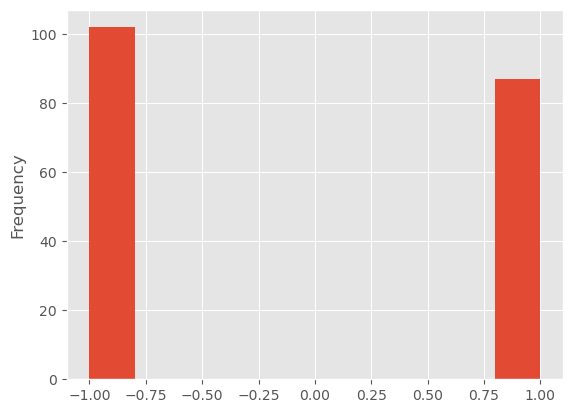

In [76]:
plt.style.use('ggplot')

daily_df['signal_daily'].plot(kind='hist')

plt.show()

## 4. Merge with intraday data and calculate intraday indicators to form the intraday signal.

* Calculate all intraday indicators and intraday signal.

In [77]:
final_df = intraday_5min_df.reset_index()\
                            .merge(daily_df[['signal_daily']].reset_index(),
                                   left_on='date',
                                   right_on='Date')\
                            .drop(['date','Date'], axis=1)\
                            .set_index('datetime')

final_df['rsi'] = pandas_ta.rsi(close=final_df['close'],
                                length=20)

final_df['lband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,0]

final_df['uband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,2]

final_df['signal_intraday'] = final_df.apply(lambda x: 1 if (x['rsi']>70)&
                                                            (x['close']>x['uband'])
                                             else (-1 if (x['rsi']<30)&
                                                         (x['close']<x['lband']) else np.nan),
                                             axis=1)

final_df['return'] = np.log(final_df['close']).diff()

final_df

,open,low,high,close,volume,signal_daily,rsi,lband,uband,signal_intraday,return
datetime,,,,,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN,NaN,NaN,NaN,NaN,0.000018
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN,NaN,NaN,NaN,NaN,0.001269
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN,NaN,NaN,NaN,NaN,0.005589
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN,NaN,NaN,NaN,NaN,-0.000146
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,NaN,62.861699,6677.365065,6715.855435,NaN,0.000128
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,NaN,63.165869,6679.544207,6716.559793,NaN,0.000070
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,NaN,61.954798,6682.379916,6716.534084,NaN,-0.000158


## 5. Generate the position entry and hold until the end of the day.

In [78]:
final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['signal_daily']==1)&(x['signal_intraday']==1)
                                        else (1 if (x['signal_daily']==-1)&(x['signal_intraday']==-1) else np.nan),
                                        axis=1)

final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign']\
                                  .transform(lambda x: x.ffill())

final_df['forward_return'] = final_df['return'].shift(-1)

final_df['strategy_return'] = final_df['forward_return']*final_df['return_sign']

daily_return_df = final_df.groupby(pd.Grouper(freq='D'))['strategy_return'].sum()

## 6. Calculate final strategy returns.

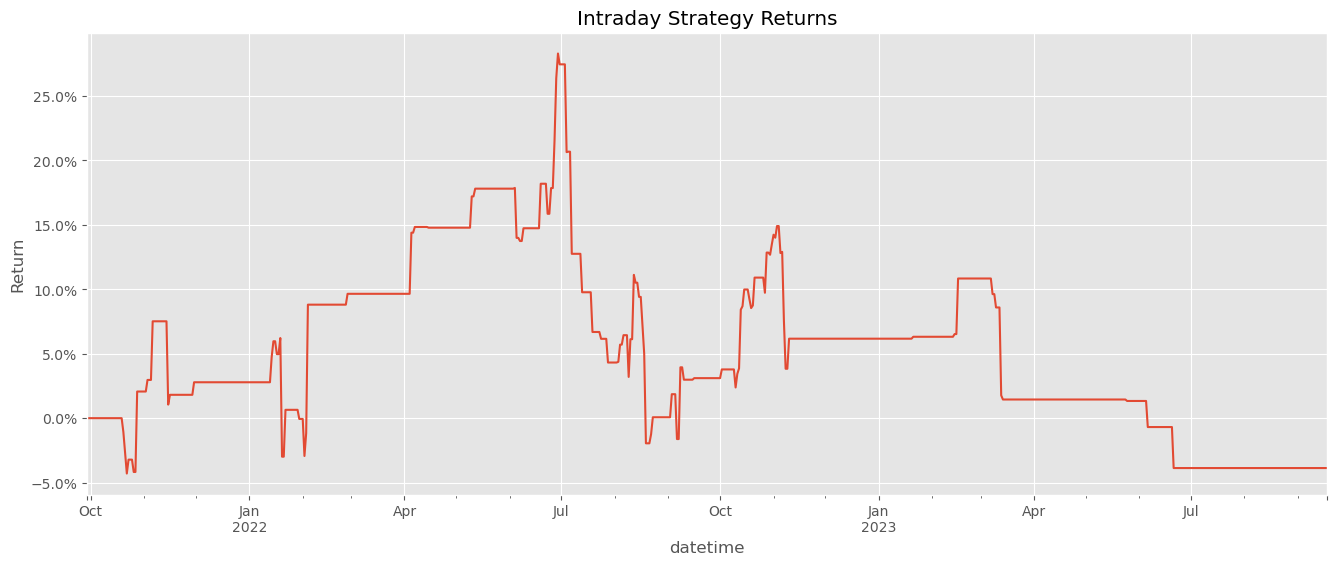

In [79]:
import matplotlib.ticker as mtick

strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)

strategy_cumulative_return.plot(figsize=(16,6))

plt.title('Intraday Strategy Returns')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
                                                                            